In [343]:
import pandas as pd
import import_ipynb
import json
from types import SimpleNamespace
import torch
import torch.nn as nn
import torch.optim as optim

%run data_preprocess.ipynb
%run helper.ipynb
%run models/disaggregation/ResNet_seq2seq.ipynb
%run wrapper.ipynb


In [344]:
with open("Config/model_config.json") as json_data:
    data = json.load(json_data, object_hook=lambda d: SimpleNamespace(**d))
    model_params = data.resnet_seq2seq
    model_params.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [345]:
dataPreProcess = DatasetPreprocess()
helper = PrepareData(model_params)

In [346]:
# train_loader, test_loader, scaler_train, scalar_test = helper.get_data_loader(dataPreProcess)

In [347]:
columns = ['ev_car', 'total_power_consumption', 'Month', 'Day_of_week', 'Day',
       'Hour', 'holiday']

In [348]:
train_data, train_ground_truth, test_data, test_ground_truth, scaler_train, scalar_test = helper.get_data_loader(dataPreProcess, columns)

## Resnet_seq2seq

In [339]:
model_resnet = ResNetSeq2Seq(model_params).to(model_params.device)

In [340]:
criterion = nn.MSELoss()  # Mean Squared Error loss
optimizer = optim.Adam(model_resnet.parameters(), lr=0.001)

In [341]:
wrapper = Wrapper(model_params)

In [342]:
ground_truth, predicted = wrapper.model_train(model_resnet, train_data, train_ground_truth, optimizer, criterion)

torch.Size([256, 128, 20])
torch.Size([256, 128, 19])


RuntimeError: Given groups=1, weight of size [128, 6, 3], expected input[256, 128, 19] to have 6 channels, but got 128 channels instead

In [302]:
ground_truth.shape, predicted.shape

(torch.Size([23040, 1]), torch.Size([23040, 1]))

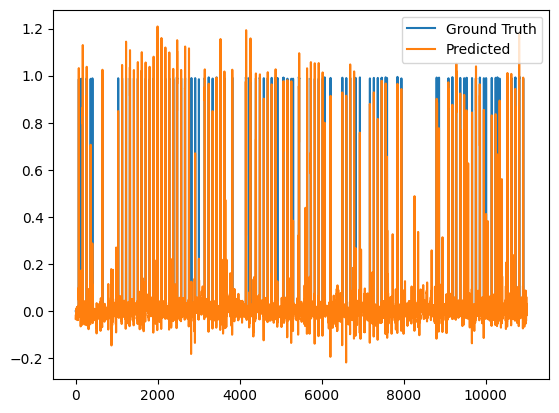

In [303]:
from matplotlib import pyplot as plt


plt.plot(ground_truth[1000:12000].cpu().detach().numpy(), label='Ground Truth')
plt.plot(predicted[1000:12000].cpu().detach().numpy(), label='Predicted')
plt.legend()
plt.show()

In [304]:
test_ground_truth_seq2seq, predicted_seq2seq = wrapper.model_test(model_resnet, test_data, test_ground_truth)

In [305]:
r2, rmse, mae = wrapper.evaluation_metrics(test_ground_truth_seq2seq, predicted_seq2seq)

In [306]:
print(f"R2 Score: {r2}")
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")

R2 Score: 0.6391004323959351
RMSE: 0.12234993278980255
MAE: 0.0435762032866478


In [312]:
#reverse scaling
predicted_seq2seq = scalar_test.inverse_transform(predicted_seq2seq.cpu().detach().numpy())
test_ground_truth_seq2seq = scalar_test.inverse_transform(test_ground_truth_seq2seq.cpu().detach().numpy())

ValueError: non-broadcastable output operand with shape (11520,1) doesn't match the broadcast shape (11520,7)

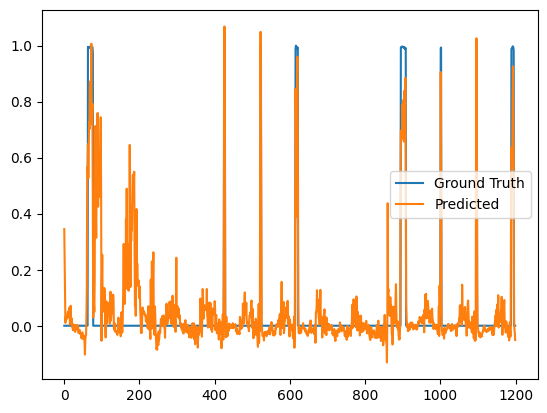

In [310]:
plt.plot(test_ground_truth_seq2seq[000:1200].cpu().detach().numpy(), label='Ground Truth')
plt.plot(predicted_seq2seq[000:1200].cpu().detach().numpy(), label='Predicted')
plt.legend()
plt.show()